## Stereo Vision (10pts)
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this lab we will apply our knowledge in the lectures on recovering depth from two 2D images.

### 1. Dense Stereo
In this section, you will be given two images taken from two different cameras whose viewing angles are parallel to each other and they are aligned with each other. Note: I'm resizing the images to 30% of their original size to speed up computations but probably better results can be obtained by running at full resolution.

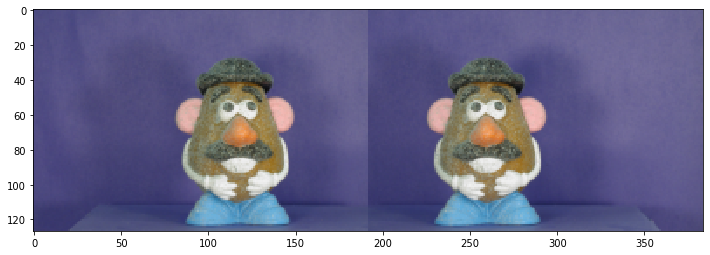

In [15]:
import scipy as sp
import scipy.misc
import imageio
import numpy as np
import matplotlib.pyplot as plt
import skimage
from urllib.request import urlopen
import warnings
warnings.filterwarnings('ignore', '.*second argument.*',)

# Try maybe downloading the images in case the CS webserver goes down.
root = 'http://www.cs.virginia.edu/~vicente/vision/'

# Load image captured with the left camera.
img_left = root + 'potato-head-left.png'
img1 = imageio.imread(img_left)
img1 = skimage.transform.resize(img1, (int(0.3*img1.shape[0]), int(0.3*img1.shape[1])));

# Load image captured with the right camera.
img_right = root + 'potato-head-right.png'
img2 = imageio.imread(img_right)
img2 = skimage.transform.resize(img2, (int(0.3*img2.shape[0]), int(0.3*img2.shape[1])));

# Display the images.
plt.figure(figsize = (12, 12))
plt.imshow(np.concatenate((img1, img2), axis = 1))
plt.show()

### 2. Dense Stereo - Disparity Map (NCC) (4pts)
Compute the disparity map of the two images using NCC (normalized cross correlation) over pixel windows of size 5x5 and display the resulting disparity map. Refer to the formula below where $p_1$ and $p_2$ are the patches being compared:

$$\text{NCC}(p_1, p_2) = \frac{\hat{p}_1 \cdot \hat{p}_2}{\lVert \hat{p}_1 \rVert \; \lVert \hat{p}_2 \rVert}; \quad \text{ s.t. } \quad \hat{p} = p - \text{mean}(p)$$

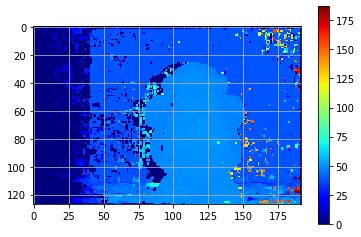

In [20]:
window_size = 5

# Your code goes here.
def ncc(p1, p2):
  p1 = p1.reshape(-1)
  p2 = p2.reshape(-1)
  p1 = p1 - np.mean(p1)
  p2 = p2 - np.mean(p2)
  return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

img1_ = np.pad(img1, ((2, 2), (2, 2), (0, 0)), mode='constant', constant_values=(0, 0))
img2_ = np.pad(img2, ((2, 2), (2, 2), (0, 0)), mode='constant', constant_values=(0, 0))
disparity_map = np.zeros((len(img1), len(img1[0])))
for r in range(2, len(img1_) - 2):
  for c in range(2, len(img1_[0]) - 2):
      p1 = img1_[r - 2 : r + 2, c - 2: c + 2,:]
      cmax = float('-inf')
      for k in range(2, len(img1_[0]) - 2):
        p2 = img2_[r - 2: r + 2, k - 2 : k + 2,:] 
        v = ncc(p1, p2) 
        if v > cmax: 
          cmax = v
          disparity_map[r - 2][c - 2] = c - k

# Negative values have to be mistakes, so let's supress them.
plt.figure()
plt.imshow(disparity_map * (disparity_map > 0), cmap = 'jet')
plt.colorbar()
plt.grid('off')
plt.show()

### 3. Dense Stereo - Recovering Depth (3pts)
In this section you will convert the disparity map into a depth map assumming that the baseline distance between the two camera centers is 76mm, and the focal length is 19.35mm. Also, filter out dephts outside the Mr. Potatohead (e.g. background and mistakes). Feel free to filter out mistakes in the output (post-processing), in whatever way you find useful. A sample output is included below. Please check this page to see how to plot in 3D https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

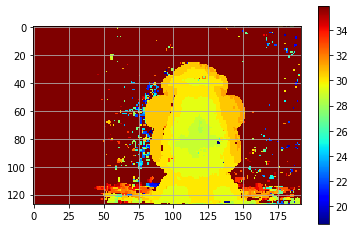

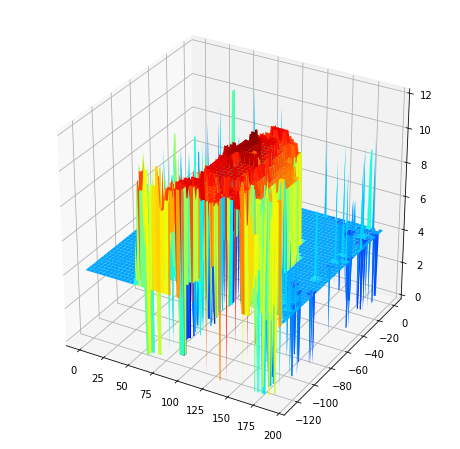

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get rid of depths that don't make sense (coming from the background)
disparity_map = disparity_map * (disparity_map > 40)
disparity_map = disparity_map * (disparity_map < 80)

# Negative disparities do not make sense so I'm ignoring those too.
depth_map = np.zeros(disparity_map.shape)
depth_map[disparity_map > 0] = (19.35 * 76) / \
                               disparity_map[disparity_map > 0]

depth_map[disparity_map == 0] = depth_map.max()


# This visualizes depth maps in 2D.
plt.figure()
plt.imshow(depth_map, cmap = 'jet')
plt.colorbar()
plt.grid('off')
plt.show()

Z = 40 - depth_map
Z[Z > 12] = 0

X = np.arange(0, depth_map.shape[1])
Y = np.arange(0, depth_map.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(X, -Y, Z, cmap='jet',
                       linewidth=0, antialiased=True)
ax.set_zlim(0, 12)
plt.show()

### 4. Dense Stereo - Texture Mapping (3pts)
Repeate the same 3D plot but map the pixels in the input image to the 3D mesh using the colors option of the plot_surface function. I'm providing here the code, so no coding needed, you just need to run the code and make sure it outputs something similar (or better) to what is shown below.

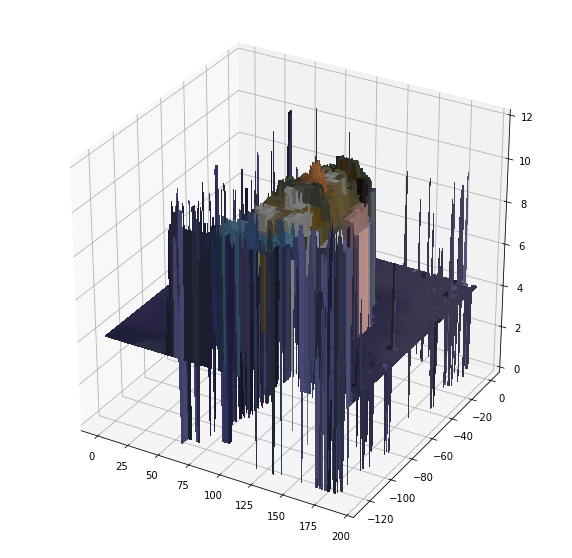

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection = '3d')

# This works if you computed the disparity map with respect
# to the left image (img1).
rgba = np.ones((img1.shape[0], img1.shape[1], 4))
rgba[:, :, :3] = img1
surf = ax.plot_surface(X, -Y, Z, facecolors = rgba,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 12)
plt.show()

**Final comments:** In this lab we reconstructed depth information from the disparity map between two images taken of the same object from two slightly different viewpoints. You experienced two ways to compute the disparity map. You also had to deal with removing artifacts after the disparity map computation.

Credits: The images were used in assignments at Stony Brook University. Prof. Dimitris Samaras, Prof. Manuel Oliveira and others seemed to have used this at some point or another but I am actually not sure of the original person capturing the image, or the time when it was captured. Toy story was released in 1995, so it has to be after that. If you capture a similar image and your disparity map computation works, please share the images with the instructor.